# Manufacturing Maintenance Case Study

Say we have a large amount of historical maintenance work-order (MWO) data stored up, but we don't quite know what to do with it yet. This case study will walk through the initial parsing of the MWO natural-language data from the technicians, to some preliminary analysis of machines, and finally visualization of potential failure modes maintenance request types. Hopefully it will give you a good idea of how Nestor can assist you in analyzing the rich, existing data in your MWO's, and how easy it can be to correlate it to other fields you might be recording. 


The primary workflow for Nestor in this case study (when used as a python library) is: 

1. Import data, determining 
    - what columns contain useful (well-defined) categories
    - what columns contain natural language to be tagged with the Nestor UI
    - what columns could be used for date-stamping/time-series analysis


2. Perform any cleaning necessary on categorical and time-series data. 
    - This is not necessarily within the scope of Nestor, but:
    - Python+Pandas makes it fairly straight forward 
    - and compatible with the Nestor output tags!


3. Tag natural language data using Nestor/NestorUI
    - Nestor can give you initial statistics about your data, immediately, but:
    - Nestor is built as a *human-in-the-loop* tool, meaning that 
    - you will be a crucial part of the process, and Nestor makes implementing your annotation lightning-fast. 
    

4. Import the tags created by Nestor, and perform analyses
    - Nestor UI is designed to create a vocabulary file, quickly mapping discovered concepts to clean *tags*. 
    - we've also built several tools to help you perform initial analyses on the tags (with more to come!)

We'll start by loading up some common packages and setting our plotting style (for consistency):

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def set_style():
    # This sets reasonable defaults for font size for a figure that will go in a paper
    sns.set_context("paper")
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
set_style()

For the interactive plots we'll need Holoviews, with the Bokeh backend:

## Data Preparation 

### Import Data

Nestor will be parsing through the NLP data soon, but first we need to determine what else might be useful for us. In this case study, we'll be using the recorded machine number, the date the MWO was recieved, technician names, and of course, the written descriptions left by our technicians. 

In this particular case, we'll be focusing primarily on the (anonymized) machine types `A` and `B`. 

In [4]:
data_dir = Path('../..')/'data'/'sme_data'
df = pd.read_csv(data_dir/'MWOs_anon.csv')

df.date_received = pd.to_datetime(df.date_received)
print(f'There are {df.shape[0]} MWO\'s in this dataset')

There are 3438 MWO's in this dataset


In [5]:
# example data: 
df.loc[df.mach.str.contains('A\d|B\d', na=False),
       ['mach', 'date_received', 'issue', 'info', 'tech']].head(10)

mach date_received                                              issue  \
0    A5    2015-01-14                                           No power   
2   A18    2015-02-27                        Check / Charge Accumulators   
3   A23    2015-02-27                          Hyd leak at saw atachment   
4   A24    2015-02-27            CS1008 setup change over / from ARC1004   
5   A27    2015-02-27  Gears on saw attachment tight and grinding per...   
6   A33    2015-02-27                      Check and charge Accumulators   
7    A8    2015-02-27                     St# 14 milling spindle repairs   
8    B2    2015-02-27                                     Hydraulic leak   
9    B3    2015-02-27                             Turrets leaking A & B    
10   B5    2015-02-27           Spindle carrier not indexing / Over Feed   

                                                 info  \
0   Replaced pin in pendant and powered machine -P...   
2                                            Where OK   
3   Replaced seal in saw attachment but still leak...   
4                  Completed / Threading unit rewired   
5   Replaced saw attachment with rebuilt unit / Re...   
6                                 Checked and charged   
7                                            Reapired   
8             Replaced ruptured hydraulic line Side B   
9               Turrets removed and cleaned of chhips   
10                                                NaN   

                                 tech  
0   angie_henderson, michele_williams  
2                    nathan_maldonado  
3                    michele_williams  
4       ethan_adams, michele_williams  
5                    michele_williams  
6                     cristian_santos  
7                    michele_williams  
8            gina_moore, dylan_miller  
9                    nathan_maldonado  
10           gina_moore, dylan_miller

### Starting Nestor

The first thing we can do is collect, combine, and cleanse our NLP data, to get a better idea of what it looks like going into Nestor. To do this, let's import the main text mining module in Nestor, `nestor.keyword`, which helps us with keyword definition and extraction. 

The `NLPSelect` object is a transformer in the style of `scikit-learn`, which will take in defined names for columns containing our original NLP data, and transform that data with it's `.transform()` method.

In [6]:
from nestor import keyword as kex
# merge and cleanse NLP-containing columns of the data
nlp_select = kex.NLPSelect(columns = ['issue', 'info'])
raw_text = nlp_select.transform(df)

Let's see what the most common MWO's in our data look like, without the punctuation or filler-words to get in the way: 

In [7]:
raw_text.value_counts()[:10]

base cleaning requested completed                 15
broken bar feeder chain repaired                  14
base needs to be cleaned completed                 7
chip conveyor jam cleared                          5
bar feeder chain broken repaired                   5
bar loader chain broken repaired                   5
broken feeder chain repaired                       5
replace leaking dresser control valve replaced     3
workzone light inop                                3
clean base completed                               3
dtype: int64

Interesting. We see a number of repetitive base-cleaning requests being entered in identically, along with some requests to fix a broken chain on the bar-feeder. However, there's alarmingly verbatim repeats, and we see a lot of overlap even in the top 10 there. This is where **Nestor** comes in. 

Similar to the above, we can make a `TokenExtractor` object that will perform statistical analysis on our corpus of MWO's, and return the concepts it deems "most important". There's a lot in here, but essentially we will get an output of the _most important concepts_ (as **tokens**) in our data. We do this with the scikit-learn `TfIdfVectorizer` tool (which transforms our text into a bag-of-words vector model), along with some added features, like a method to score and rank individual concepts. 

Let's see what tokens/concepts are most important:

In [8]:
tex = kex.TokenExtractor()
toks = tex.fit_transform(raw_text)  # bag of words matrix. 

print('Token\t\tScore')
for i in range(10):
    print(f'{tex.vocab_[i]:<8}\t{tex.scores_[i]:.2e}')

Token		Score
replaced	1.86e-02
broken  	9.68e-03
st      	9.51e-03
unit    	8.41e-03
inop    	7.27e-03
motor   	7.21e-03
spindle 	7.17e-03
leak    	6.88e-03
repaired	6.75e-03
valve   	6.74e-03


These are small scores, but they're normalized to add to 1: 

In [9]:
tex.scores_.sum()

1.0

Note that the current default is to limit the number of extracted concepts to the top 5000 (can be modified in the `TokenExtractor` kwargs, but in practice should be more than sufficient. 


### Nestor UI and Tags



In [11]:
vocab_fname = data_dir/'vocab.csv' 
vocab = kex.generate_vocabulary_df(tex, filename=vocab_fname)
tags_df = kex.tag_extractor(tex, raw_text, vocab_df=vocab)

attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!
intialized successfully!


In [12]:
tags_read = kex._get_readable_tag_df(tags_df)
tags_read.join(df[['issue', 'info', 'tech']]).head(4)

I                         NA       P  \
0          machine, cable, pin, pendant          possible, powered   short   
1                                  part  tech, harness, smartscope  broken   
2                           accumulator                                      
3  hydraulic, saw, attachment, marcel_l           reapirs, pending    leak   

                   S      U X                        issue  \
0           replaced  power                       No power   
1      repair, order             Smartscope harness broken   
2  check, charge, ok           Check / Charge Accumulators   
3           replaced   seal      Hyd leak at saw atachment   

                                                info  \
0  Replaced pin in pendant and powered machine -P...   
1                      Parts ordered / Tech repaired   
2                                           Where OK   
3  Replaced seal in saw attachment but still leak...   

                                tech  
0  angie_henderson, michele_williams  
1                   gina_moore, tech  
2                   nathan_maldonado  
3                   michele_williams

In [13]:
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('tagged tokens: ', vocab[vocab.NE!=''].NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
tagged tokens:  686
total tags:  307


NE  alias  notes  score
NE                         
     1      3      1   2274
I    1    154      8    368
P    1     26      1     77
S    1     29      1    105
U    1     91      7    130
X    1      4      1      4

Tag completeness: 0.77 +/- 0.19
Complete Docs: 798, or 23.21%
Empty Docs: 15, or 0.44%
Docs have at most 13 tokens (90th percentile)


Text(0.5,0,'precision (PPV)')

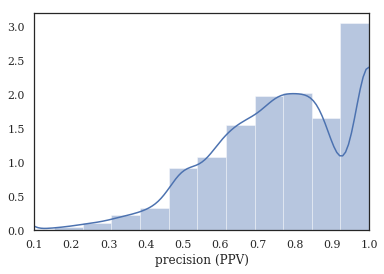

In [15]:
# tag-completeness of work-orders?
tag_pct, tag_comp, tag_empt = kex.get_tag_completeness(tags_df)

nbins = int(np.percentile(tags_df.sum(axis=1), 90))
print(f'Docs have at most {nbins} tokens (90th percentile)')

sns.distplot(tag_pct.dropna(), bins=nbins, kde_kws={'cut':0})
plt.xlim(0.1, 1.0)
plt.xlabel('precision (PPV)')


### Context Expansion (simplified)

In [16]:
vocab = pd.read_csv(vocab_fname, index_col=0)
vocab2 = pd.read_csv(data_dir/'2g_vocab.csv', index_col=0)

tag_df, tag_relation, NA_df = kex.ngram_keyword_pipe(raw_text, vocab, vocab2)  

intialized successfully!



intialized successfully!


In [17]:
all_tags = pd.concat([tag_df, tag_relation])
tags_read = kex._get_readable_tag_df(all_tags)
tags_read.head(10)

I              P P I  \
0        cable, machine, pendant, pendant cable, pin          short       
1                                               part         broken       
2                                        accumulator                      
3  attachment, hydraulic, marcel_l, saw, saw atta...           leak       
4                          thread, thread unit, unit                      
5  alex_b, attachment, gear, saw, saw attachment,...                      
6                                        accumulator                      
7                             mill, spindle, station                      
8                    hydraulic, hydraulic line, line  leak, rupture       
9                                       chip, turret           leak       

                           S S I       U  
0                   replaced       power  
1              order, repair              
2          charge, check, ok              
3                   replaced        seal  
4            complete, setup      change  
5  rebuild, remove, replaced              
6              charge, check              
7                     repair          14  
8                   replaced              
9              clean, remove

## Measuring Machine Performance

### Failure Inter-arrival Times, by Machine


Ordered by total occurences (i.e. "distribution certainty")

- Time between occurences of `broken` tag.
- low $\rightarrow$ bad
- e.g. `A34`, `B19`, and `A14` all seem rather low

What could be the central problems with these machines?

<Figure size 360x720 with 0 Axes>

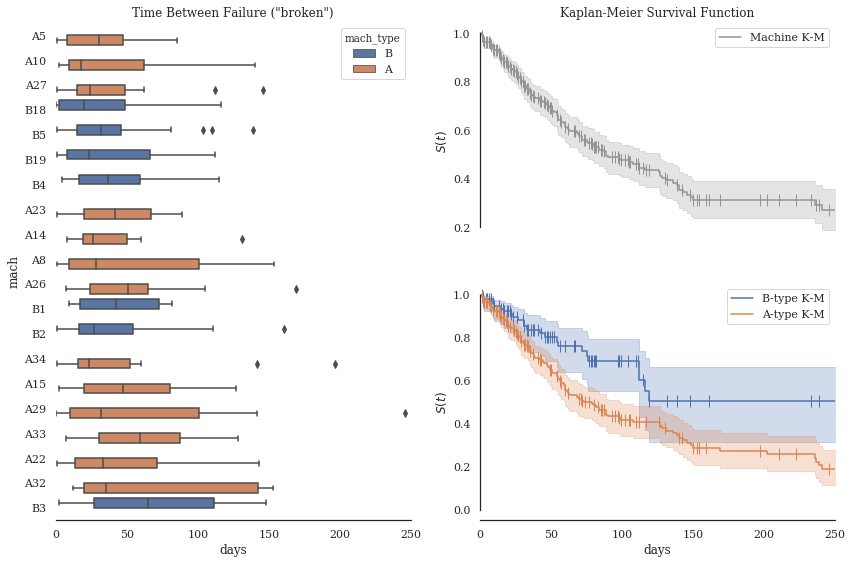

In [18]:
import warnings
warnings.simplefilter(action='ignore')

# samp = ['broken', 'motor' ]
h_or_i = df.mach.str.match(r'^[AB][0-9]*$').fillna(False)
is_broke = (tag_df.P['broken']>0)
# df.mach[h_or_i]
cond = h_or_i & is_broke

idx_col = pd.DatetimeIndex(df.date_received)
# cond = (tag_df.P['broken']>0)#|(tag_df.S['replace']>0)
sample_tag = tag_df.loc[cond,tag_df.loc[cond].sum()>1]

sample_tag.columns = sample_tag.columns.droplevel(0)

sample_tag = pd.concat([sample_tag, df.mach[cond]], axis=1)
sample_tag['date'] = idx_col[cond]
sample_tag.loc[:,'mach_type'] = sample_tag.mach.str[0]#.astype('category')
sample_tag['tbf'] = sample_tag.sort_values(['mach','date']).groupby('mach')['date'].diff()

sample_tag.loc[:,'tbf'] = sample_tag.tbf/pd.Timedelta(days=1)
sample_tag.mach_type.value_counts()
plt.figure(figsize=(5,10))
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

samps = sample_tag[['mach_type', 'tbf', 'mach']].dropna()
order = samps.mach.value_counts().index


import matplotlib.gridspec as gridspec
fig = plt.figure(tight_layout=True, figsize=(12,8))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[:,0])
sns.boxplot(data=samps, y='mach', x='tbf', 
            hue='mach_type', orient='h', 
            order=order[:20], notch=False,
           ax = ax1)
plt.xlabel('days');
plt.title('Time Between Failure ("broken")')
ax1.set(xlim=(0,250));
sns.despine(ax=ax1, left=True, trim=True)

from lifelines import WeibullFitter, ExponentialFitter, KaplanMeierFitter

def mask_to_ETraw(df_clean, mask, fill_null=1.):
    """Need to make Events and Times for lifelines model
    """
    filter_df = df_clean.loc[mask]
    g = filter_df.sort_values('date_received').groupby('mach')
    T = g['date_received'].transform(pd.Series.diff)/pd.Timedelta(days=1)

    # assume censored when parts replaced (changeout)
    E = (~(tag_df.S['replaced']>0)).astype(int)[mask]
    T_defined = (T>0.)&T.notna()
    return T[T_defined], E[T_defined]

ax3 = fig.add_subplot(gs[-1,-1])
ax2 = fig.add_subplot(gs[0,-1], sharex=ax3)

T, E = mask_to_ETraw(df, cond)
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E, label='Machine K-M')
kmf.plot(show_censors=True, censor_styles={'marker':'|'}, ax=ax2, color='xkcd:gray')
ax2.set(xlim=(0,250), ylabel=r'$S(t)$', title='Kaplan-Meier Survival Function');
sns.despine(ax=ax2, bottom=True, trim=True)

i_ = df.mach.str.match(r'^[B][0-9]*$').fillna(False)
T, E = mask_to_ETraw(df, i_&is_broke)
kmf.fit(T, event_observed=E, label='B-type K-M')
kmf.plot(show_censors=True, censor_styles={'marker':'|'}, ax=ax3)

h_ = df.mach.str.match(r'^[A][0-9]*$').fillna(False)
T, E = mask_to_ETraw(df, h_&is_broke)
kmf.fit(T, event_observed=E, label='A-type K-M')
kmf.plot(show_censors=True, censor_styles={'marker':'|'}, ax=ax3)


ax3.set(xlim=(0,250), ylabel=r'$S(t)$', xlabel='days');
sns.despine(ax=ax3,  trim=True)

Markers ( | ) indicate a _censored_ observation, interpreted as a maintenance event with no replacements (no 'replaced' tag occurrence).

- where "problems" aren't listed, issue is generally routine maintenance. 
- **Assumption**: Problem and Solution tags are almost entirely independent sets. 
- We get a precise list of what *isn't* known for free...the "Unknowns". 

### Top Tag occurences, by Machine

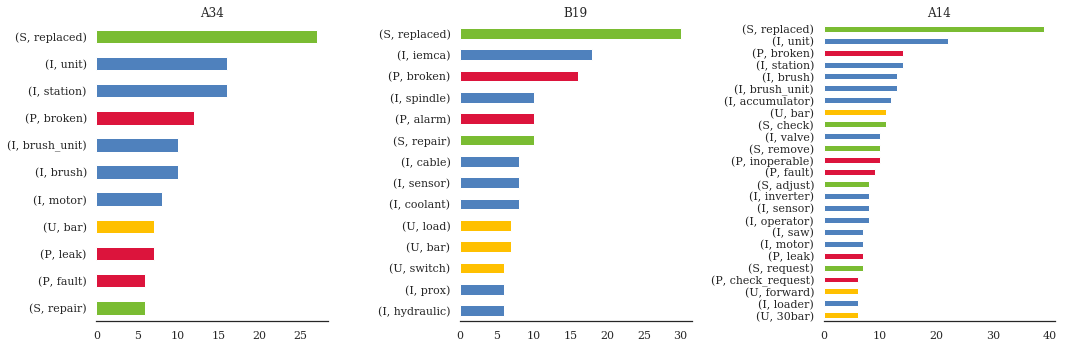

In [19]:
from nestor.tagplots import color_opts
machs = ['A34', 'B19', 'A14']
def machine_tags(name, n_reps):
    ismach = df['mach'].str.contains(name, case =False).fillna(False)
    return tag_df.loc[ismach,(tag_df.loc[ismach,:].sum()>=n_reps).values]
f, ax = plt.subplots(ncols=3, figsize=(15, 5))

for n, mach in enumerate(machs):
    mach_df = machine_tags(mach,  6).sum().sort_values()
    mach_df.plot(kind='barh', color=[color_opts[i] for i in mach_df.index.get_level_values(0)], ax=ax[n])
    ax[n].set_title(mach)
    sns.despine(ax=ax[n], left=True)
plt.tight_layout()

- `A34` issues with `motor`, `unit`, `brush`
- `B19` `alarm`s and/or `sensors`, potentially coolant-related
- `A14` wide array of issues, including `operator` (!?)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
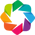

In [18]:
import holoviews as hv
hv.extension('bokeh')
%opts Graph [width=600 height=400]

In [37]:
%%output size=150 backend='bokeh' filename='machs'
%%opts Graph (edge_line_width=1.5, edge_alpha=.3)
%%opts Overlay [width=400 legend_position='top_right' show_legend=True] Layout [tabs=True]
from nestor.tagplots import tag_relation_net
import networkx as nx
kws = {
    'pct_thres':50,
    'similarity':'cosine',
    'layout_kws':{'prog':'neatopusher'},
    'padding':dict(x=(-1.05, 1.05), y=(-1.05, 1.05)),
      }

layout = hv.Layout([tag_relation_net(machine_tags("A34",  2), name='A34',**kws),
                    tag_relation_net(machine_tags("B19",  2), name='B19',**kws),
                    tag_relation_net(machine_tags("A14",  2), name='A14',**kws)
                   ])
layout

:Layout
   .A34.I :Overlay
      .A34.I  :Graph   [source,target]   (weight)
      .A34.II :Labels   [x,y]   (tag)
   .B19.I :Overlay
      .B19.I  :Graph   [source,target]   (weight)
      .B19.II :Labels   [x,y]   (tag)
   .A14.I :Overlay
      .A14.I  :Graph   [source,target]   (weight)
      .A14.II :Labels   [x,y]   (tag)

## Measuring Technician Performance

In [20]:

is_base_cleaner = df.tech.str.contains('margaret_hawkins_dds').fillna(False)
print('Margaret\'s Top MWO\'s')
df['issue'][is_base_cleaner].value_counts()


Margaret's Top MWO's


Base cleaning requested                                              14
Base needs to be cleaned                                              8
Clean base                                                            4
Base clean                                                            3
Base cleaning req                                                     2
Cooling unit faults                                                   2
Base required cleaning                                                2
Base cleaning                                                         2
Base cleaning -caused fire                                            1
Chips in base obstructin coolant flow to pump                         1
Shipping cart has worn wheels                                         1
Base clean request before setup                                       1
Repair paper filter system                                            1
Base cleaning Requested                                         

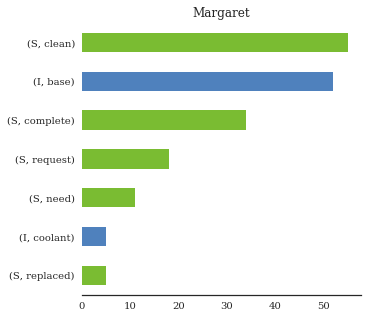

In [21]:
# df['Description'][df['Tech Full Name'].str.contains('Lyle Cookson').fillna(False)]

def person_tags(name, n_reps):
#     techs = kex.token_to_alias(kex.NLPSelect().transform(df.tech.to_frame()), tech_dict)
    isguy = df.tech.str.contains(name).fillna(False)
    
    return tag_df.loc[isguy,(tag_df.loc[isguy,:].sum()>=n_reps).values]

people = ['margaret_hawkins_dds',
          'nathan_maldonado',
          'angie_henderson',
         ]
marg_df = person_tags(people[0],  5).sum().sort_values()

plt.figure(figsize=(5,5))
marg_df.plot(kind='barh', color=[color_opts[i] for i in marg_df.index.get_level_values(0)])
sns.despine(left=True)
plt.title('Margaret');

Threshold to tags happening >=5x
- we can quickly gauge the number of Margaret's *total* "base cleanings" as 45-50 
- Say we want to compare with other, more "typical" technicians...

$\rightarrow$ *small problem*...

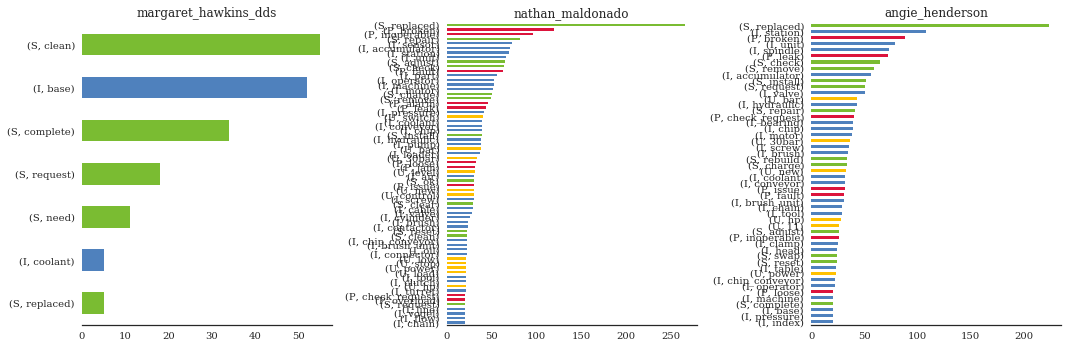

In [22]:

f, ax = plt.subplots(ncols=3, figsize=(15, 5))
thres = [5, 20, 20]
for n, mach in enumerate(people):
    mach_df = person_tags(mach,  thres[n]).sum().sort_values()
#         mach_df = mach_df[mach_df>=5]
    mach_df.plot(kind='barh', color=[color_opts[i] for i in mach_df.index.get_level_values(0)], ax=ax[n])
    ax[n].set_title(mach.split(' ')[0])
    sns.despine(ax=ax[n], left=True)
plt.tight_layout()

In [23]:
%%output size=80 backend='bokeh' filename='techs'
%%opts Graph (edge_line_width=1.5, edge_alpha=.7)
%%opts Layout [tabs=True]


kws = {
    'kind': 'sankey',
    'similarity': 'count',
}

layout = hv.Layout([
    tag_relation_net(person_tags('nathan_maldonado', 25), name='Nathan',**kws),
    tag_relation_net(person_tags('angie_henderson', 25), name='Angie',**kws),
    tag_relation_net(person_tags('margaret_hawkins_dds', 2), name='Margaret',**kws),
    tag_relation_net(person_tags("tommy_walter", 2), name='Tommy',**kws),
    tag_relation_net(person_tags("gabrielle_davis", 2), name='Gabrielle',**kws),
    tag_relation_net(person_tags("cristian_santos", 2), name='Cristian',**kws)
])#.cols(1)
layout

:Layout
   .Nathan.I    :Sankey   [source,target]   (weight)
   .Angie.I     :Sankey   [source,target]   (weight)
   .Margaret.I  :Sankey   [source,target]   (weight)
   .Tommy.I     :Sankey   [source,target]   (weight)
   .Gabrielle.I :Sankey   [source,target]   (weight)
   .Cristian.I  :Sankey   [source,target]   (weight)